Exercise 2: Video processing
=======================

To complete the exercise, follow the instructions and complete the missing code and write the answers where required.  All points, except the ones marked with **(N points)** are mandatory. The optional tasks require more independet work and some extra effort. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Sometimes there are more optional exercises and you do not have to complete all of them, you can get at most 100 points.

In [2]:
# First, tun this cell to download the data used in this exercise
import zipfile, urllib.request, io, os
if not os.path.isfile("token"):
    print("Downloading exercise material")
    zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("http://data.vicos.si/lukacu/multimedia/exercise2.zip").read())).extractall()

**Note about video visualization:** Videos cannot be visualized directly in Jupyter, you have to render them to a file and then link a file which is loaded by the browser and visualized. Most browsers can play MP4 files, so that should be your format of choice.

**Required libraries:** In this exercise you will be reading and writing videos. This will be done using the SciKit Video IO library `skvideo` that you must install and import to your notebook.

In [2]:
%matplotlib notebook

from IPython.display import Video
Video("shaky.mp4")

Assignment 1: Video stabilization
--------

Video stabilization is the process of estimating the motion between consecutive frames, and applying an image transformation that either cancels out the motion or diminishes its effects. It is important to note that video stabilization reduces the effective image size, so one should not consider it to be a substitution for a proper video capture procedure.

The goal of this assignment will be the compensation of translational vibrations, which cause a video frame from time t to be shifted according to vector v $t = (x_t , y_t )$. The underlying idea is as follows:

 1. First, you need to select a stable point in the image, preferably one that can be tracked throughout the whole length of the video.
 2. Having chosen the point to track, you need to estimate its motion trajectory throughout the video, relative to its position in the first frame.
 3. Compensate for motion in each frame by translating the image by the negative value of estimated relative position of the tracked point, and gather the translated frames in new, stabilized, video.
 
The tracking of the selected point can be achieved by using the *normalized cross-corelation* (NCC) method. Using this method, you will compare the patch around the selected point with patches in the subsequent images, and find the best match. The normalized cross-correlation between the *template patch* and a given *image patch* is computed using the following formula:

\begin{equation}
\frac{1}{n} \sum_{x,y}\frac{(f(x,y) - \overline{f})(t(x,y) - \overline{t})}{\sigma_f \sigma_t},
\end{equation}

where $t(x,y)$ denotes the template, and $f(x,y)$ denotes the image patch that we are comparing to the template. $n$ denotes the number of pixels in the patch (both template and image patch are of same dimensions); $\overline{f}$ and $\overline{t}$ denote the mean, while $\sigma_f$ and $\sigma_t$ denote the standard deviation of the image and the template patch, respectively. This way one can determine the position of the template inside a larger image by computing the *similarity scores* between the template and all patches inside the image.




 * Read the `shaky.mp4` video using `skvideo.io.vread` and display several frames from the in-memory 4D representation.


(900, 240, 426, 3)


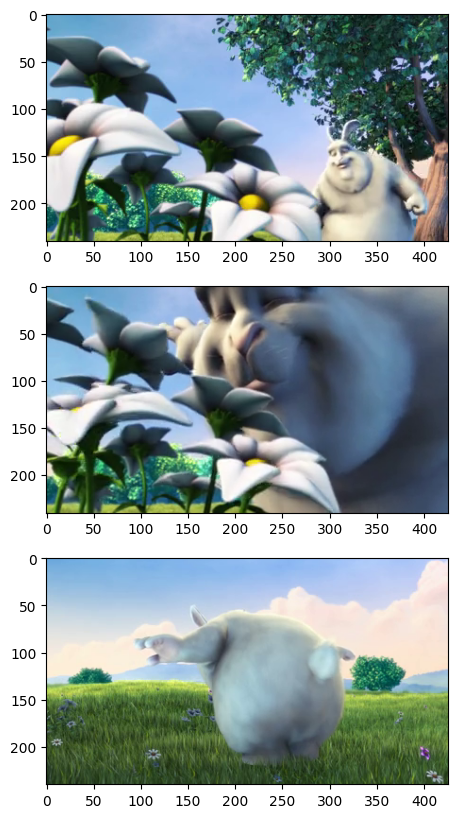

In [1]:
import skvideo.io
import numpy as np
np.float = np.float64
np.int = np.int64
from matplotlib import pyplot as plt

videodata = skvideo.io.vread("bigbuck.mp4")
print(videodata.shape) # The video matrix is N x H x W x C (N = number of frames)

_, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[1].imshow(np.squeeze(videodata[100, :, :, :]))
ax[2].imshow(np.squeeze(videodata[150, :, :, :]))
ax[0].imshow(np.squeeze(videodata[1, :, :, :])) # To visualize a single frame, we have to remove the singleton dimension

plt.show() # Display the image

 * Write a function `track_point`, which, given the video data, coordinates of the initial point, size of the surrounding template patch, and the size of the search neighborhood, computes and returns the trajectory that corresponds to motion of the point throughout the whole video sequence. To find the best template match in subsequent frames, use the built-in function `skimage.feature.match_template` that calculates a normalized cross-correlation in a 2D matrix. Use the following arguments for the function: `pad_input=False`, `mode='constant'`, `constant_values=0`.
 
   Hints: In our case we are matching a small matrix from the first frame (template) with a larger matrix in the current frame (patch). The patch matrix is not the entire frame, but a region cut around the position of the template in the previous frame (starting with the initial position for the first frame). The assumption of locality of motion is one of the core ideas of feature tracking. It is, however, very important that you take into account the offset of your search patch when calculating the position of the template in a frame. If you have problems you can test your solution by not progressing in time, but search for the best match in the first frame - the solution should be the initial position of the patch, if your trajectory is drifting then you are doing something wrong.

In [2]:
from skimage.feature import match_template
from skimage.color import rgb2gray

def track_point(video, x, y, template_size = 11, patch_size = 40):

    length, height, width, _ = video.shape

    frame = rgb2gray(np.squeeze(video[1, :, :, :])) # convert image to grayscale
    x1 = int(max(1, x - template_size / 2))
    y1 = int(max(1, y - template_size / 2))
    x2 = int(min(width, x + template_size / 2 - 1))
    y2 = int(min(height, y + template_size / 2 - 1))
    template = frame[y1:y2, x1:x2] # cut the reference patch (template) from the first frame

    track_x = [x]
    track_y = [y]

    for i in range(2, length):
        frame = rgb2gray(np.squeeze(video[i, :, :, :])) # Extract current frame and convert it grayscale
        # TODO: cut-out a patch of search_size x search_size from 'frame' with the center in the point's previous position (i-1)
        #    Then use match_template to find the best match of the template in the patch
        #    Select best match (maximum) and determine its position. Update x and y and append new x,y values to track_x,track_y
        dx, dy = track_x[-1], track_y[-1]
        new_x1 = int(max(1, dx - patch_size // 2))
        new_y1 = int(max(1, dy - patch_size // 2))
        new_x2 = int(min(width, dx + patch_size // 2 - 1))
        new_y2 = int(min(height, dy + patch_size // 2 - 1))
        cutout = frame[new_y1:new_y2, new_x1:new_x2]

        matche = match_template(cutout, template, pad_input=False, mode='constant', constant_values=0)
        
        bestmatch = np.argmax(matche)
        yi = bestmatch // matche.shape[1]
        xi = bestmatch % matche.shape[1]
        newx = xi + new_x1
        newy = yi + new_y1

        track_x.append(newx)
        track_y.append(newy)

    return track_x, track_y

 * Test your point tracking, use the previously-written function `track_point` to obtain the point's trajectory and display it over the last frame of the video sequence. Experimentally determine the template patch size and the search-neighborhood size that result in stable tracking of the point.
 
   For point (x=239, y=178) you should get a trajectory similar to the one visualized in the image below.
   
   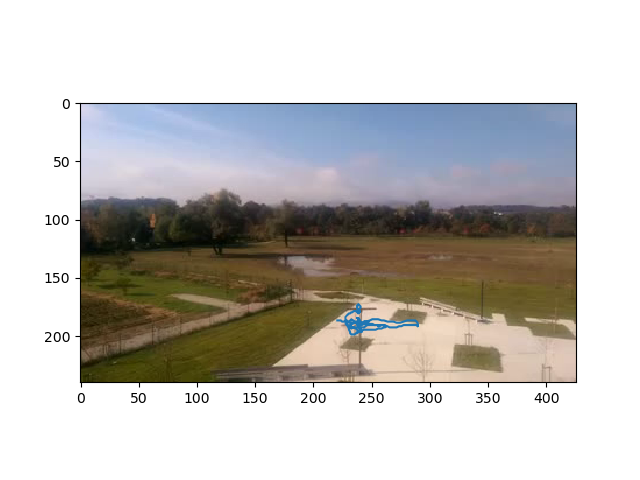



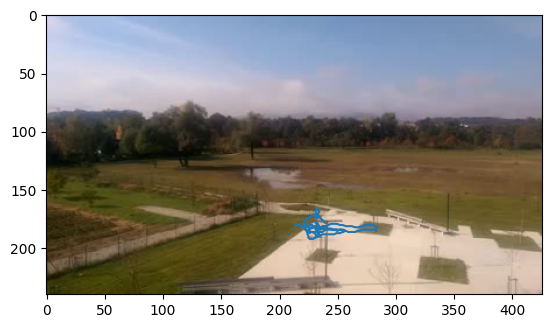

In [3]:
import skvideo.io
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Cursor

video = skvideo.io.vread("shaky.mp4")
image = np.squeeze(video[1, :, :, :]) 

point = (239, 178)

X, Y = track_point(video, 239, 178)

# Draw trajectory on top of the first frame from video...
image = np.squeeze(video[1, :, :, :]) 
figure = plt.figure()
plt.gca().imshow(image) 
plt.gca().plot(X, Y) 

 * Check the performance of point tracking for several different points. Choose corners, lines and homogeneous surface as the initialization. Visualize the the results in the same manner as above.

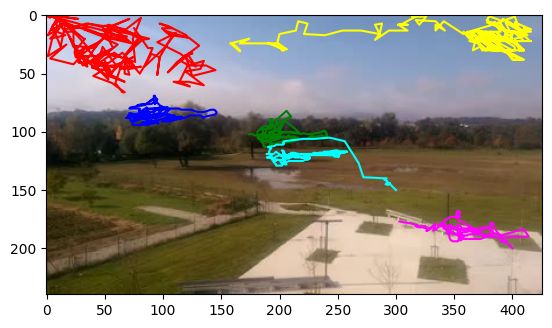

In [4]:
point1 = (0, 0)
point2 = (100, 80)
point3 = (200, 100)
point4 = (300, 150)
point5 = (400, 200)
point6 = (400, 20)

X1, Y1 = track_point(video, point1[0], point1[1])
X2, Y2 = track_point(video, point2[0], point2[1])
X3, Y3 = track_point(video, point3[0], point3[1])
X4, Y4 = track_point(video, point4[0], point4[1])
X5, Y5 = track_point(video, point5[0], point5[1])
X6, Y6 = track_point(video, point6[0], point6[1])

# Draw trajectory on top of the first frame from video...
image = np.squeeze(video[1, :, :, :]) 
figure = plt.figure()
plt.gca().imshow(image) 
plt.gca().plot(X1, Y1, color='red')
plt.gca().plot(X2, Y2, color='blue')
plt.gca().plot(X3, Y3, color='green') 
plt.gca().plot(X4, Y4, color='cyan') 
plt.gca().plot(X5, Y5, color='magenta') 
plt.gca().plot(X6, Y6, color='yellow')   

plt.show()

*  On which points from the previous task does point tracking work well, and on which it does not? Explain why.

* Write a program in which you make use of the trajectory, obtained by `track_point`. The program should create a new video sequence, in which the original images are translated by offsets that correspond to negative estimated motion vectors. In other words, for each frame from original video, create an image of same size, and copy the original pixel elements with an offset that you obtain from the computed trajectory. If no pixel from the source image maps to a pixel in the destination image, that pixel should be left black. You can use function and classes in `skimage.transform` to implement transformation (note that the `warp` function will convert image to float by default, use `preserve_range` parameter to avoid it). 

  Write the video sequence to disk frame by frame using function `skvideo.io.vwrite` (unfortunatelly the function tends to exit before the video is fully written so you may get errors when trying to play it too soon) If you want to play the video in browser you have to use H.264 encoding: `vwrite(file, data, outputdict={'-vcodec': 'libx264'})`.

In [5]:
from skimage.transform import EuclideanTransform, warp
from skvideo.io import vwrite

outvideo = np.ndarray(video.shape, dtype=np.uint8)
X, Y = track_point(video, 100, 100)

for i in range(len(X)):
    dx = X[i] - X[0]
    dy = Y[i] - Y[0]

    # Calculate Euclidean transformation based on motion vectors
    t = EuclideanTransform(translation=(dx, dy))
    frame = np.squeeze(video[i, :, :, :]) 
    frame = warp(frame, t, output_shape=(video.shape[1], video.shape[2]), preserve_range=True)
    outvideo[i, :, :, :] = frame
    
# write stabilized video to disk
vwrite("shaky_stable.mp4", outvideo, outputdict={'-vcodec': 'libx264'})

# show stabilized video
from IPython.display import Video
Video("shaky_stable.mp4")

 * **(5 points)** Currently the stabilized video is filled with a lot of black area around the borders that is the result of the fact that we have to shift the images in order to compensate for the motion. But since the scene our test video is more or less stationary, at least some of the information about these regions can be recovered from the overall video. 
 
   Implement and demonstrate an algorithm that fills these black pixels with information obtained from a mean image obtained by stabilizing the entire video and computing a mean over pixel values for all images (it is best to assign value `NaN` to all pixels that are not available in a certain stabilized image and then use function `numpy.nanmean` that filters out these values before it calculates mean so that these values do not influence the estimate, e.g. make the entire image darker).

In [6]:
# Hint: We can calculate mean value of Red channel without NAN values with np.nanmean(video[:,:,:,0], axis=0)
#       Do similar for other channels. Use np.stack((....), axis=0) to stack channels together...

filled = np.empty(video.shape[1:4], dtype=np.float32)
filled[:] = np.nan

outvideo_filled = np.ndarray(video.shape, dtype=np.float32)

for i in range(video.shape[0]):
    # TODO: Estimate motion vectors dx, dy (same as in excercise above), Calculate Euclidean transformation, Replace NaN values in 'frame' with pixels from the averaged background...
    # Get current frame...
    # ... and warp it/translate it based on calculated Euclidean transformation
    # Set cval=np.nan to fill black areas around the borders with NaN values...
    
    # Convert frame back to uint8 and add it to output video...
    frame = frame.astype(np.uint8)
    outvideo_filled[i, :, :, :] = frame
    
# Write video to disk
vwrite("shaky_filled.mp4", outvideo_filled, outputdict={'-vcodec': 'libx264'})

# Display video
from IPython.display import Video
Video("shaky_filled.mp4")

 * The kind of stabilization that we have obtained so far is not always desirable; depending on how unstable the source video is, we may end up discarding significant parts of images. In addition, completely static video sequences tend to look unnatural. As our main goal is compensation of sudden movements, we will upgrade our stabilization with smoothing. Modify the script from the previous step so that it will use function `smooth_trajectory` to smooth the trajectory before using it for stabilization. Save the resulting video file to `smooth.mp4`. Explain how function `smooth_trajectory` performs smoothing. 
 
   **Important:** Remember the effect of the border when filtering. The default strategy for most convolution implementation is to insert zeros to the sides of the signal. This works well if the signal starts and ends close to zero, but produces artefacts if the signal is offset. You can solve this by offsetting the signal (your trajectory) by a fixed value so that it will start and end close to zero.

In [7]:
import numpy as np

# Generate a gaussian kernel
def gauss_2d(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0: 
        h /= sumh
    return h

# Smooth trajectory using gaussian kernel
def smooth_trajectory(track_x, track_y):
    s = 20 # kernel shape
    G = gauss_2d([s, 1], s / 6)
    G = np.reshape(G, len(G))
    
    # padding to get same results as we would using matlab "conv" function
    npad = len(G) - 1
    track_x_padded = np.pad(track_x, (npad // 2, npad - npad // 2), mode='constant')
    track_y_padded = np.pad(track_y, (npad // 2, npad - npad // 2), mode='constant')
    
    # smoothen movement in x-axis
    smooth_x = np.convolve(track_x_padded, G, 'valid')

    # smoothen movement in y-axis
    smooth_y = np.convolve(track_y_padded, G, 'valid')
    
    return smooth_x, smooth_y

# Perform smoothing of the trajectory, be careful about the boundary values!
X, Y = track_point(video, 100, 100)
smoothed_x, smoothed_y = smooth_trajectory(X, Y)

# TODO: Use softened trajectories for video stabilization, save the resulting video to a file
outsmoothvideo = np.ndarray(video.shape, dtype=np.uint8)

for i in range(len(smoothed_x)):
    dx = smoothed_x[i] - smoothed_x[0]
    dy = smoothed_y[i] - smoothed_y[0]
    t = EuclideanTransform(translation=(dx, dy))
    frame = np.squeeze(video[i, :, :, :]) 
    frame = warp(frame, t, output_shape=(video.shape[1], video.shape[2]), preserve_range=True)
    outsmoothvideo[i, :, :, :] = frame
    
# write stabilized video to disk
vwrite("smooth.mp4", outsmoothvideo, outputdict={'-vcodec': 'libx264'})

# show stabilized video
from IPython.display import Video
Video("smooth.mp4")

 * **(5 points)** In a lot of cases tracking only a single point may not be desirable, the tracking can fail or can be unreliable. It is better to look at more points and calculate their consistency for each frame to estimate motion. Implement and demonstrate an algorithm that tracks more (three or more) points and at every frame selects the ones that are agreeing on translation of the image (point in the same direction) and computes their average estimate. Then render a stabilized video using these more robust estimates. Do not forget to describe your approach with comments.

In [11]:
# TODO



 * **(10 points)** Sometimes, estimating only translation may not be enough to stabilize the video, you may also have to account for rotation. Actually the video can also contain other deformations, but for this task we will only focus on rotation. Use video stored in file `rotation.mp4` for this task and try to remove it. You will have to track more points and use them to estimate rotation from them. Hint: it is best to first complete other assignments in this exercise because there may be some valuable information there. Do not forget to describe your approach with comments.

In [12]:
# TODO


Assignment 2: Chroma key background removal
----

The goal of this assignment is to remove background from a video based on its (distinct) color. This technique is known in the entertainment industry as *chroma key* or greenscreen. We will first familiarize ourselves with color spaces, then you will implement background replacement on some stock footage videos.

The color information can be encoded using different color spaces, with each color space having its own characteristics. This assignment will demonstrate how a relatively simple conversion between the RGB and the HSV color spaces helps us achieve interesting results.

 * Read video from the file `chromakey1.jpg` and select first image. Display the image on screen, both as a color image in the RGB color space, and each of its channels as a separate grayscale image.

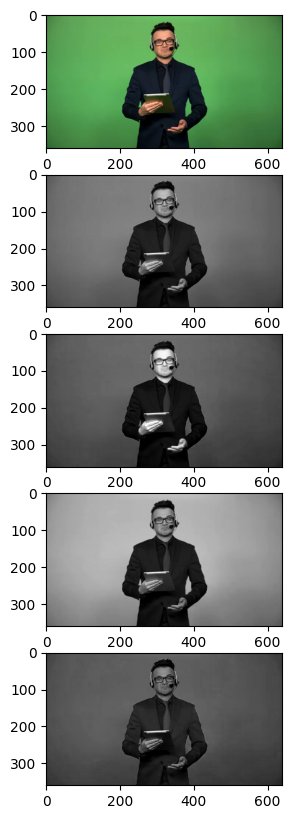

In [8]:
# TODO

chromavid1 = skvideo.io.vread("chromakey1.mp4")
_, ax = plt.subplots(5, 1, figsize=(10, 10))
chromaimg1 = np.squeeze(chromavid1[0, :, :, :])
ax[0].imshow(chromaimg1)
ax[1].imshow(np.mean(chromaimg1, 2),cmap='gray')
ax[2].imshow(chromaimg1[:,:,0],cmap='gray')
ax[3].imshow(chromaimg1[:,:,1],cmap='gray')
ax[4].imshow(chromaimg1[:,:,2],cmap='gray')

plt.show()

 * Convert the image from the RGB color space to the YCbCr color space, using the built-in function `skimage.color.rgb2ycbcr`, and display each channel as a separate grayscale image. When working with resulting matrices, take a note of their type; the original image in the RGB color space is stored in a matrix of type `uint8`, while the converted image is stored in a matrix of type `float64` (real values in range 0 to 1). How do you interpret the channels of the HSV color space with respect to the original RGB channels?

<class 'numpy.uint8'>
<class 'numpy.float64'>


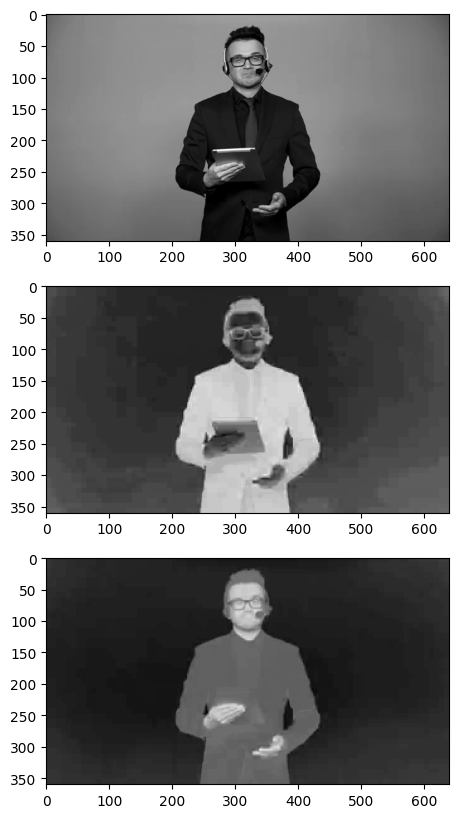

In [9]:
# TODO

from skimage.color import rgb2ycbcr

chromaimg1_ycbcr = rgb2ycbcr(chromaimg1)
print(type(chromaimg1[0,0,0]))
print(type(chromaimg1_ycbcr[0,0,0]))
_, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(chromaimg1_ycbcr[:,:,0],cmap='gray')
ax[1].imshow(chromaimg1_ycbcr[:,:,1],cmap='gray')
ax[2].imshow(chromaimg1_ycbcr[:,:,2],cmap='gray')

plt.show()

 * Different color spaces are also useful when we wish to threshold the image. For example, in the RGB color space, it is difficult to determine regions that belong to a certain shade of a color. To demonstrate this, load the image from file `trucks.jpg`, and threshold its blue channel with the threshold value of 200. Display the original and the thresholded image next to each other. Since blue is a primary color this works to some degree, now try to isolate yellow regions. What is the problem?

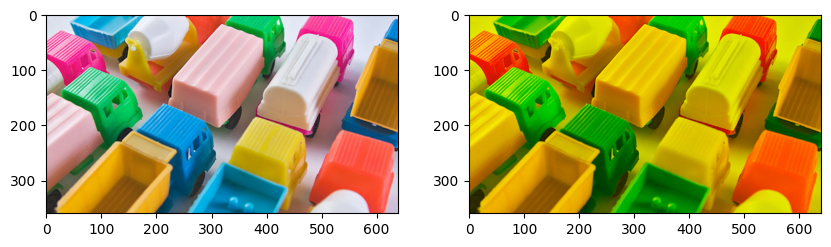

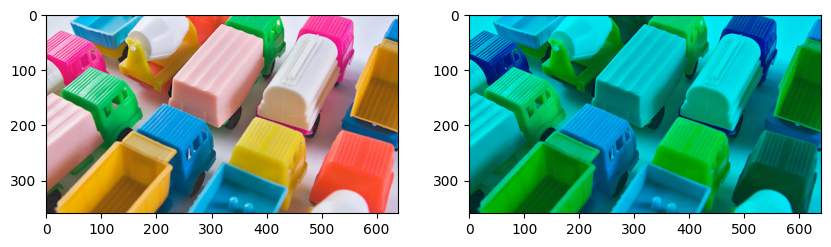

In [10]:
# TODO
from skimage import io

firetrucks = io.imread("trucks.jpg")
threshold = np.copy(firetrucks)
threshold[:,:,2] = firetrucks[:,:,2] > 200
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(firetrucks)
ax[1].imshow(threshold)
plt.show()

#r,g,b  -- y = r,g
threshold2 = np.copy(firetrucks)
threshold2[:,:,0:1] = firetrucks[:,:,0:1] < 200
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(firetrucks)
ax[1].imshow(threshold2)
plt.show()

 * If we want to extract a custom color, the best way is to use a reference from the input image or video. Write a snippet that extracts a single pixel from a given frame (e.g. first frame of the video) in YCrCb color space and compares it to all other pixels in the image. Select a pixel of the green background from a frame of `chromakey1.mp4` (try not to select the top-left pixel, but a more inner pixel). Then compare it to all other pixels in the same frame using Euclidean distance. Use `scipy.spatial.distance.cdist` function to efficiently compute distances together with `numpy.reshape` to transform image to a 2D matrix of per-row vectors. Visualize the distances when comparing distances in YCrCb and in CrCb subspace. What is the advantage of not using Y component?

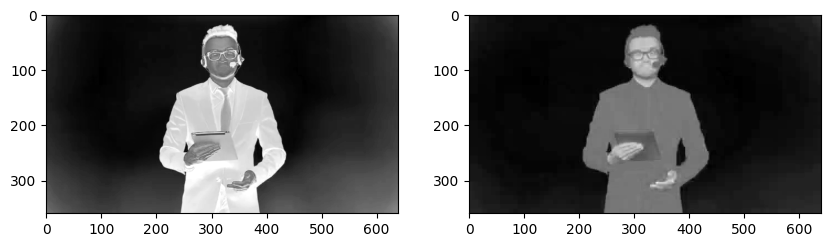

In [11]:
from scipy.spatial.distance import cdist

chromavid1 = skvideo.io.vread("chromakey1.mp4")
firstframe = chromavid1[0,:,:,:]
firstframe_ycrcb = rgb2ycbcr(firstframe)
pixel = firstframe_ycrcb[100,100,:]

dist = cdist(firstframe_ycrcb.reshape(-1, 3), pixel.reshape(-1, 3))
dist = dist.reshape(firstframe_ycrcb.shape[:2])

dist2 = cdist(firstframe_ycrcb[:,:,1:].reshape(-1, 2), pixel[1:].reshape(-1, 2))
dist2 = dist2.reshape(firstframe_ycrcb.shape[:2])

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(dist, cmap='gray')
ax[1].imshow(dist2, cmap='gray')
plt.show()

#Not using the Y compontent is better as it only represents the luminosity value

 * Now try to apply color isolation to the first frame of video. Use the code from the previous task to determine pixel distances in color space. Then threshold them to obtain a binary mask. Determine an appropriate threshold to separate the spleaker from the green background.

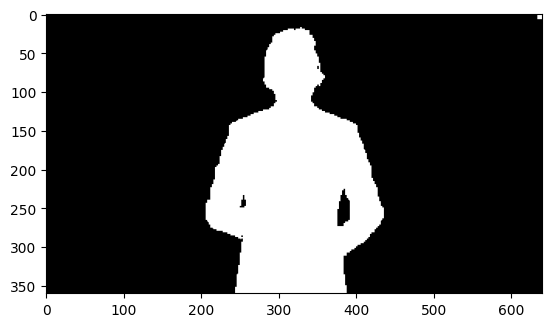

In [12]:
chroma_thresh = dist2 > 15
plt.imshow(chroma_thresh,cmap='gray')
plt.show()

 * Insert a static background (e.g. `trucks.jpg`) in the background of the reported that you have isolated in the previous task. The result should be similar to the image below.
 
   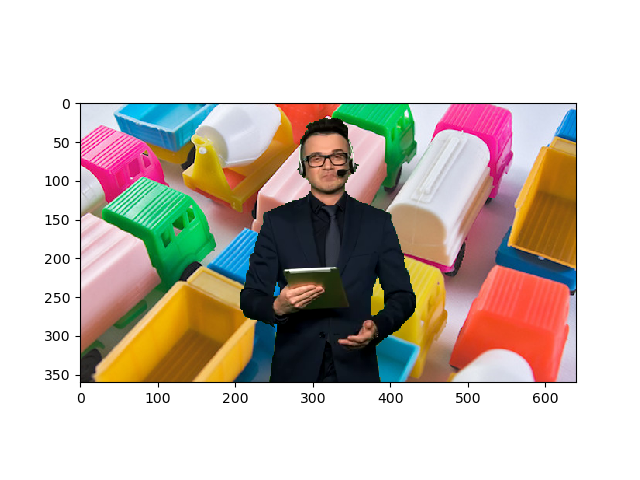

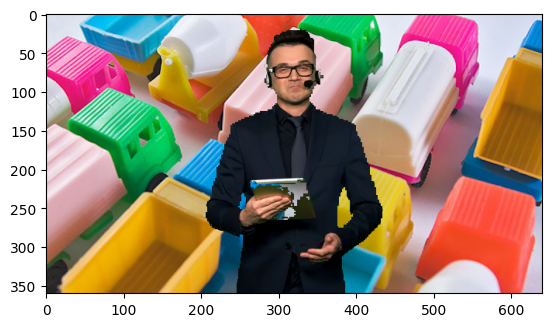

In [13]:
firetrucks = io.imread("trucks.jpg")
chromavid1 = skvideo.io.vread("chromakey1.mp4")

firstframe = chromavid1[0,:,:,:]
firstframe_ycrcb = rgb2ycbcr(firstframe)
pixel = firstframe_ycrcb[100,100,:]

dist2 = cdist(firstframe_ycrcb[:,:,1:].reshape(-1, 2), pixel[1:].reshape(-1, 2))
dist2 = dist2.reshape(firstframe_ycrcb.shape[:2])

chroma_thresh = dist2 > 30

newimg = np.copy(firstframe)
newimg_b = np.copy(firetrucks)
for i in range (0,3):
    newimg[:,:,i] = newimg[:,:,i] * chroma_thresh
    newimg_b[:,:,i] = newimg_b[:,:,i] * (1 - chroma_thresh)

final = newimg + newimg_b
plt.imshow(final)
plt.show()

* **(5 points)** Apply the greenscreen effect to the video, save it and display it. Since processing many frames is time consuming, you have to optimize your code a bit, normal for loop approaches will not be accepted for this task.

In [14]:
# TODO
firetrucks = io.imread("trucks.jpg")
chromavid1 = skvideo.io.vread("chromakey1.mp4")
for j in range(chromavid1.shape[0]):
    frame = chromavid1[j]
    frame_ycrcb = rgb2ycbcr(frame)
    pixel = frame_ycrcb[100,100,:]

    dist2 = cdist(frame_ycrcb[:,:,1:].reshape(-1, 2), pixel[1:].reshape(-1, 2))
    dist2 = dist2.reshape(frame_ycrcb.shape[:2])

    chroma_thresh = dist2 > 30

    newimg = np.copy(frame)
    newimg_b = np.copy(firetrucks)
    for i in range (0,3):
        newimg[:,:,i] = newimg[:,:,i] * chroma_thresh
        newimg_b[:,:,i] = newimg_b[:,:,i] * (1 - chroma_thresh)

    chromavid1[j] = newimg + newimg_b

skvideo.io.vwrite("chroma.mp4", chromavid1, outputdict={'-vcodec': 'libx264'})
Video("chroma.mp4")

 * **(5 points)** Combine the point tracking algorithm from previous assignment with colorkey background replacement algorithm from this exercise. Use video file `chromakey2.mp4` as the foreground source and track on of the cross markers to determine movement of the backround. Then paste the background (e.g. `trucks.jpg`) as a moving background based on the determined trajectory. 

In [ ]:
# TODO

Assignment 3: Detection of shot transitions
----

Sudden changes in shots can be detected by observing the differences between two consecutive images in the video sequence. If the difference is small, it can most likely be attributed to changes within the shot; if the difference is large, it is most likely due to the transition between two shots. You will implement a simple detector of shot transitions based on histogram comparison. Note that this is a very simple algorithm, and if you wanted to use it in real-life applications, you would likely need to combine it with other modalities.

To compute the distance between two histograms you will use Hellinger distance that is defined as:

\begin{equation}
H(\mathbf{h}_1,\mathbf{h}_2) = \sqrt{  \frac{1}{2} \sum_{i=0}^{N-1} \Big( \sqrt{h_1(i)} - \sqrt{h_2(i)} \Big)^2 }.
\end{equation}

Note that low values of Hellinger distances signify high similarity and high values signify low similarity.


 * Load the video sequence `bigbuck.mp4` into the memory. For each image in the video sequence, compute separate histograms for red, green, and blue channel, and then concatenate them into a single vector. Start with 8-bin histograms, and later experiment with different number of bins. Use *Hellinger distance* to compute similarities between histograms of consecutive image pairs. Store the results for the entire sequence to a vector, and visualize them using the `matplotlib.pyplot.plot` function.

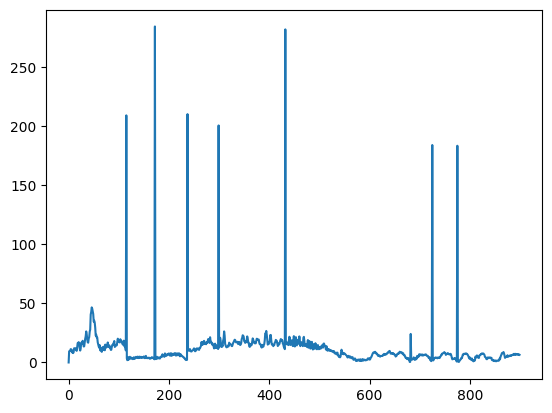

In [16]:
from skimage.exposure import histogram
import skvideo.io
import numpy as np
np.float = np.float64
np.int = np.int64
from matplotlib import pyplot as plt

def hellinger_distance(h1, h2):
    h1_sqrt = np.sqrt(h1) # Compute square root of all elements from h1
    h2_sqrt = np.sqrt(h2) # Compute square root of all elements from h2
    squared_dif = (h1_sqrt - h2_sqrt) ** 2 # Compute squared difference of h1_sqrt and h2_sqrt
    return np.sqrt( (sum(squared_dif)) / 2 ) # return hellinger distance...
    
# Load bigbuck video
video_bigbuck = skvideo.io.vread("bigbuck.mp4")
# Extract histograms for each R, G, B channel of initial image, concatenate them into a single vector 'hist_0'
hvalues_r, bins_r = histogram(video_bigbuck[0, :, :, 0], nbins=8, source_range='dtype', normalize=False)
hvalues_g, bins_g = histogram(video_bigbuck[0, :, :, 1], nbins=8, source_range='dtype', normalize=False)
hvalues_b, bins_b = histogram(video_bigbuck[0, :, :, 2], nbins=8, source_range='dtype', normalize=False)

hist_0 = np.concatenate((hvalues_r, hvalues_g, hvalues_b), axis=None)

# Placeholder for Hellinger Distances
# Here we will store frame number and Hellinger distance computed for this frame
hellinger_distances = np.ndarray([video_bigbuck.shape[0], 2], dtype=np.float64)

for i in range(1, video_bigbuck.shape[0]):
    # TODO
    # 1: Extract histograms for each R, G, B channel of current image
    # 2: Concatenate histograms for all channels into a single vector 'hist_1'
    #    example:  hist_1 = np.concatenate((r_hvalues_1, g_hvalues_1, b_hvalues_1), axis=None)
    # 3: Calculate Hellinger distances and update the list of hellinger distances...
    # 4: Update hist_0
    #1
    hvalues_ri, bins_ri = histogram(video_bigbuck[i, :, :, 0], nbins=16, source_range='dtype', normalize=False)
    hvalues_gi, bins_gi = histogram(video_bigbuck[i, :, :, 1], nbins=16, source_range='dtype', normalize=False)
    hvalues_bi, bins_bi = histogram(video_bigbuck[i, :, :, 2], nbins=16, source_range='dtype', normalize=False)
    #2
    hist_1 = np.concatenate((hvalues_ri, hvalues_gi, hvalues_bi), axis=None)
    #3
    distance = hellinger_distance(hist_0, hist_1)
    hellinger_distances[i] = [i, distance]
    #4
    hist_0 = hist_1




# Visualize the results
plt.figure()
plt.clf()
# hellinger_distances[:,0] corresponds to frame number (plotted on x-axis)
# hellinger_distances[:,1] corresponds to Hellinger distance (plotted on y-axis)
plt.plot(hellinger_distances[:,0], hellinger_distances[:,1])


 * Based on the obtained inter-frame histogram distances, estimate a threshold that will allow you to detect shot transitions. A straightforward automatic way of determining this threshold is to set the threshold to a certain portion (e.g., 20%) of the maximum value. This approach has several limitations (can you think of some?), but illustrates the general idea. Using the estimated threshold value, determine the positions of shot transitions, and visualize them by displaying five consecutive frames around each transition. Display all transitions in rows of a single figure, with each row corresponding to a single transition.

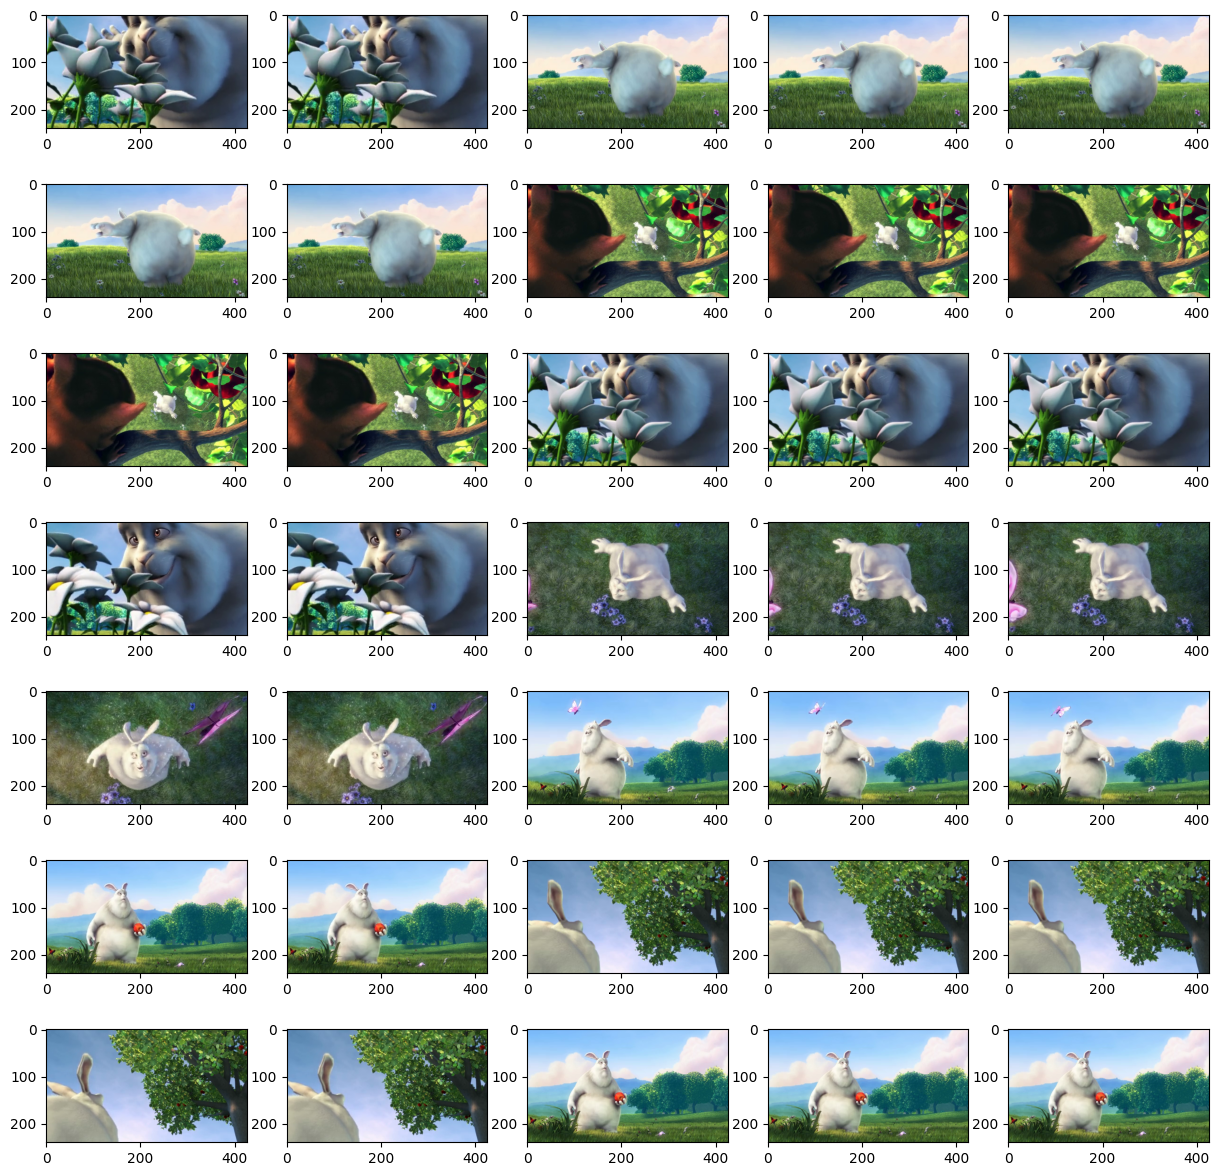

In [26]:
threshold = 0.2 * np.max(hellinger_distances[:, 1])
shots = hellinger_distances[hellinger_distances[:, 1] > threshold]

video_bigbuck = skvideo.io.vread("bigbuck.mp4")


_, ax = plt.subplots(len(shots), 5, figsize=(15, 15))

for i in range(0, len(shots)):
    for j in range(5):
        image = video_bigbuck[int(shots[i, 0])+j -2, :, :, :]
        ax[i, j].imshow(image)
plt.show()

 * **(5 points)** The previous task was based on the assumption that the video sequence contains sharp cuts. However, in real-life scenarios, this is not always the case. To make the algorithm that handles crossfades, implement the hysteresis techique described in the slides from the lectures. Set two thresholds and use them to determine the start and end of a transition by observing the difference between the start frame (triggered by an entry threshold) and the last frame of the transition (cumulative difference threshold). Visualize the detected transitions in the same way as in the previous task. Use the video sequence `crossfade.mp4` for this task.

In [ ]:
# TODO

raise NotImplementedError()

* **(5 points)** Implement the cut detection algorithm that uses edge changes or splits image in multiple regions and inspect changes individually. Both ideas are described in the lectue slides. For edge calculation or morphological operations, use functions from the `skimage` package. Demonstrate the approach on the video sequence `bigbuck.mp4`.

In [ ]:
# TODO
raise NotImplementedError()